# Importing all the libraries

In [24]:
import pandas as pd
import datetime
from pandas import Series, DataFrame
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import math
from sklearn.preprocessing import PolynomialFeatures
import matplotlib as plt

# Reading the data and making training and testing sets

In [28]:
df = pd.read_csv('IBEX.csv')
df = df.set_index('Date')
df.head()

#Selecting two columns of the dataset and creating two more
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
print(forecast_out)
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)


#Separating training and testing sets with sklearn function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

13
Dimension of X (1265, 4)
Dimension of y (1265,)


# Fitting different models and comparing them

In [29]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clflas = Lasso(alpha=0.1)
clflas.fit(X_train, y_train)

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencelas = clflas.score(X_test,y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The Lasso regression confidence is ",confidencelas)

The linear regression confidence is  0.7582984362304586
The quadratic regression 2 confidence is  0.7644186215459294
The Lasso regression confidence is  0.7909363287061199


# Making forecast (with Lasso)

In [30]:
dfforec = dfreg.copy()
forecast_set = clflas.predict(X_lately)
dfforec['Forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

last_date = dfforec.iloc[-1].name
last_date = datetime.datetime.strptime(last_date, '%Y-%m-%d')
last_unix = last_date
next_unix = last_unix - datetime.timedelta(days=forecast_out)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfforec.loc[next_date] = [np.nan for _ in range(len(dfforec.columns)-1)]+[i]

[8494.62894206 8703.11006026 8729.34262047 8709.49378253 8691.4278821
 8635.40280224 8708.1531465  8691.44609965 8755.4139091  8768.10517055
 8783.37667054 8831.01812708 8768.35724496] 0.7582984362304586 13


# Plotting

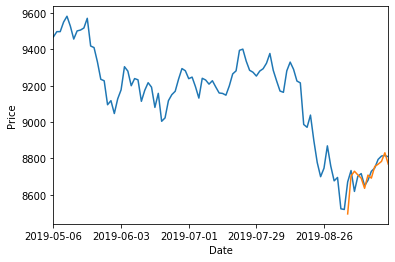

In [31]:
dfreg['Adj Close'].tail(100).plot()
dfforec['Forecast'].tail(100).plot()
plt.pyplot.xlabel('Date')
plt.pyplot.ylabel('Price')
plt.pyplot.show()